In [30]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [37]:
# Financial News Market Events - NLP Analysis
# Complete Kaggle Notebook for Financial News Dataset Analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')



# NLP Libraries
import nltk
import re
from textblob import TextBlob
from wordcloud import WordCloud
from collections import Counter
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Advanced NLP
try:
    import spacy
    # The line below was causing the error - shell commands can't be run directly in Python code
    # python -m spacy download en_core_web_sm
    # Instead, you should run this command in your terminal/command prompt before running this script
    # or use the spacy.cli module as shown below:
    import spacy.cli
    #spacy.cli.download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")
except:
    print("SpaCy not available. Install with: pip install spacy && python -m spacy download en_core_web_sm")

# Download NLTK data
nltk.download('vader_lexicon', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [6]:
# =============================================================================
# 1. DATA LOADING AND EXPLORATION
# =============================================================================

def load_financial_data():
    """Load financial news data from available formats"""
    
    # Try different file formats
    try:
        # CSV format (most common)
        df = pd.read_csv('financial_news_events.csv')
        print("✓ Loaded CSV file")
        return df
    except:
        pass 
    print("❌ Could not load any data file. Please check file paths.")
    return None

# Load the data
df = load_financial_data()

if df is not None:
    print(f"\nDataset Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print("\nFirst few rows:")
    print(df.head())
    
    print("\nData Info:")
    print(df.info())
    
    print("\nMissing Values:")
    print(df.isnull().sum())

✓ Loaded CSV file

Dataset Shape: (3024, 12)
Columns: ['Date', 'Headline', 'Source', 'Market_Event', 'Market_Index', 'Index_Change_Percent', 'Trading_Volume', 'Sentiment', 'Sector', 'Impact_Level', 'Related_Company', 'News_Url']

First few rows:
         Date                                           Headline  \
0  2025-05-21        Nikkei 225 index benefits from a weaker yen   
1  2025-05-18  Government subsidy program gives a lift to the...   
2  2025-06-25  New housing data release shows a slowdown in m...   
3  2025-07-21  Massive stock buyback program announced by a c...   
4  2025-07-23  Government spending bill is expected to stimul...   

                    Source                Market_Event        Market_Index  \
0           Times of India       Commodity Price Shock                 DAX   
1          Financial Times        Central Bank Meeting  Shanghai Composite   
2  The Hindu Business Line  Consumer Confidence Report  Shanghai Composite   
3            The Economist       

In [32]:
# =============================================================================
# 2. DATA PREPROCESSING
# =============================================================================

def validate_data(df):
    """Validate and clean the loaded data"""
    if df is None:
        return None
    
    print(f"📋 Data Validation:")
    print(f"   • Original shape: {df.shape}")
    print(f"   • Column types:")
    for col in df.columns:
        dtype = df[col].dtype
        null_count = df[col].isnull().sum()
        print(f"     - {col}: {dtype} ({null_count} nulls)")
    
    return df

def clean_text(text):
    """Clean and preprocess text data"""
    if pd.isna(text) or text is None:
        return ""
    
    # Convert to string and lowercase
    text = str(text).lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove special characters and numbers (keep some financial symbols)
    text = re.sub(r'[^a-zA-Z\s$%]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def preprocess_financial_data(df):
    """Preprocess the financial news dataset"""
    
    # Common column name mappings
    text_columns = ['text', 'content', 'news', 'headline', 'title', 'article', 'description']
    date_columns = ['date', 'timestamp', 'published_date', 'created_date', 'time']
    label_columns = ['label', 'sentiment', 'category', 'event_type', 'market_impact']
    
    # Find the text column
    text_col = None
    for col in df.columns:
        if col.lower() in text_columns:
            text_col = col
            break
    
    if text_col is None:
        print("Could not identify text column. Available columns:", list(df.columns))
        return df
    
    # Clean the text data
    df['cleaned_text'] = df[text_col].apply(clean_text)
    
    # Find date column
    date_col = None
    for col in df.columns:
        if col.lower() in date_columns:
            date_col = col
            break
    
    if date_col:
        try:
            df['date'] = pd.to_datetime(df[date_col])
        except:
            print(f"Could not parse date column: {date_col}")
    
    # Find label column
    label_col = None
    for col in df.columns:
        if col.lower() in label_columns:
            label_col = col
            break
    
    if label_col:
        df['target'] = df[label_col]
    
    return df

if df is not None:
    df = validate_data(df)
    df = preprocess_financial_data(df)
    print("\n✓ Data preprocessing completed")

📋 Data Validation:
   • Original shape: (3024, 28)
   • Column types:
     - Date: object (0 nulls)
     - Headline: object (148 nulls)
     - Source: object (0 nulls)
     - Market_Event: object (0 nulls)
     - Market_Index: object (0 nulls)
     - Index_Change_Percent: float64 (161 nulls)
     - Trading_Volume: float64 (0 nulls)
     - Sentiment: object (171 nulls)
     - Sector: object (0 nulls)
     - Impact_Level: object (0 nulls)
     - Related_Company: object (0 nulls)
     - News_Url: object (153 nulls)
     - cleaned_text: object (0 nulls)
     - date: datetime64[ns] (0 nulls)
     - target: object (171 nulls)
     - vader_compound: float64 (0 nulls)
     - vader_pos: float64 (0 nulls)
     - vader_neu: float64 (0 nulls)
     - vader_neg: float64 (0 nulls)
     - sentiment_category: object (0 nulls)
     - textblob_sentiment: float64 (0 nulls)
     - text_length: int64 (0 nulls)
     - word_count: int64 (0 nulls)
     - avg_word_length: float64 (0 nulls)
     - financial_keyw

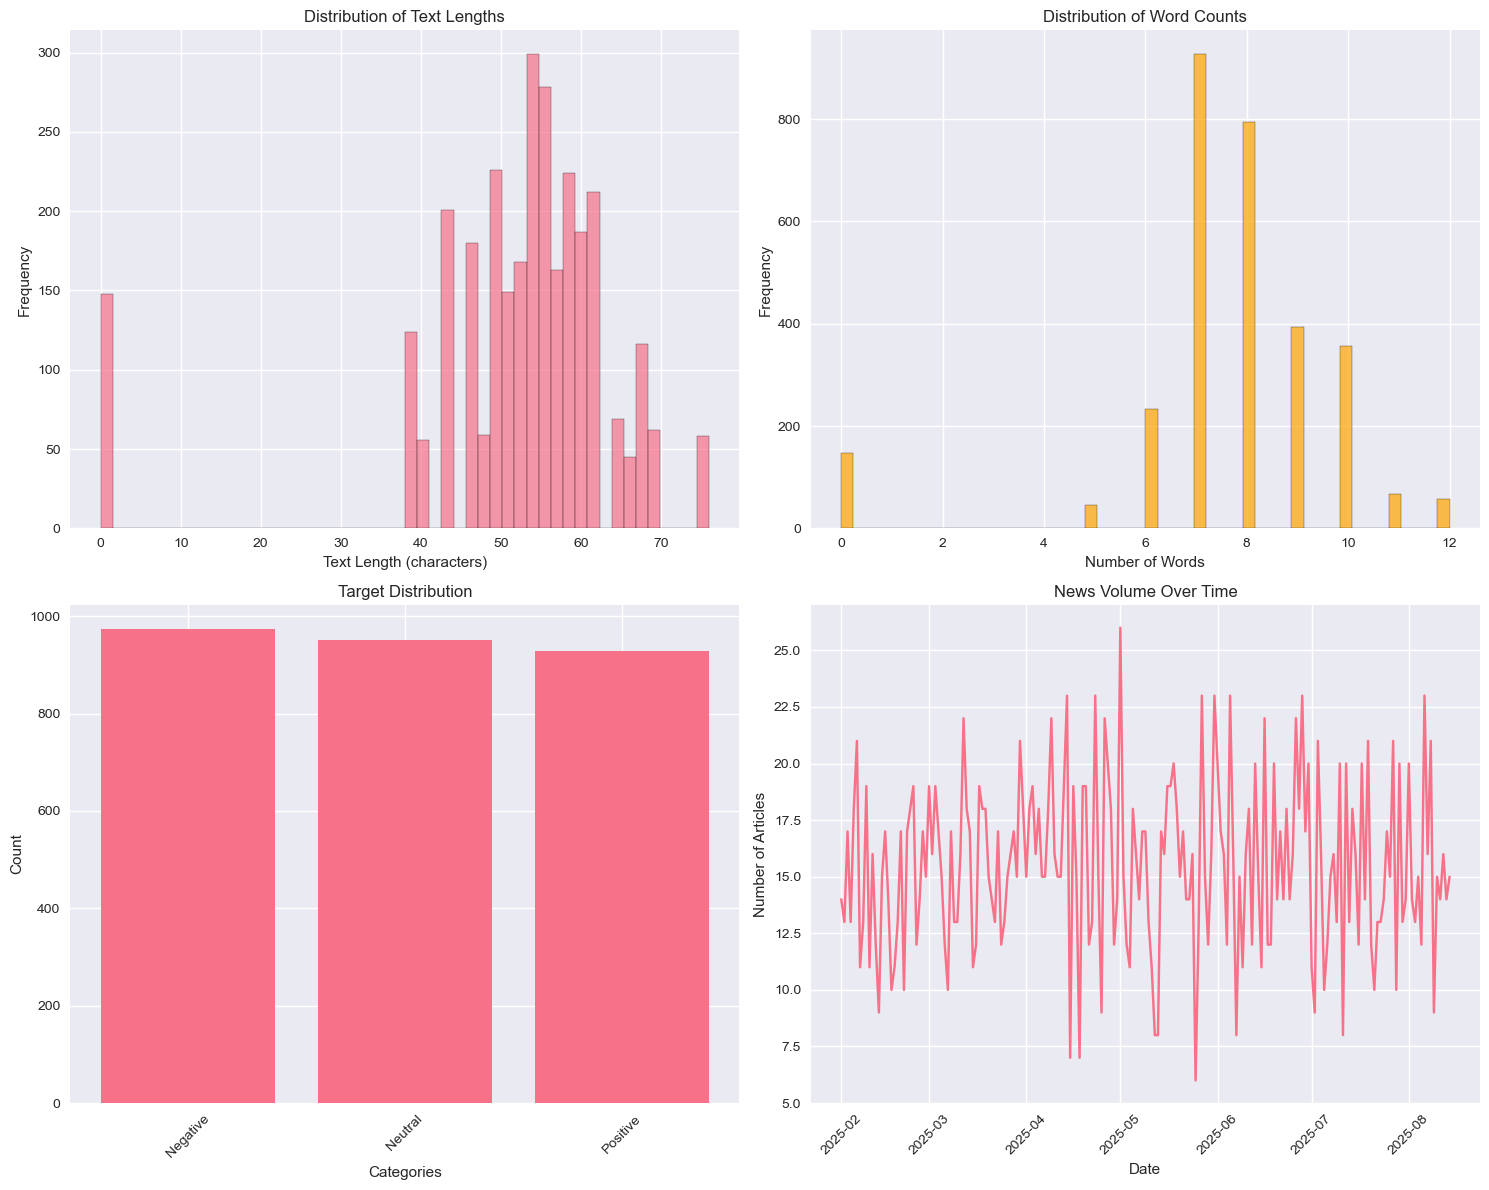

In [33]:

# =============================================================================
# 3. EXPLORATORY DATA ANALYSIS
# =============================================================================

def plot_data_overview(df):
    """Create overview plots of the dataset"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Text length distribution
    if 'cleaned_text' in df.columns:
        text_lengths = df['cleaned_text'].str.len()
        axes[0, 0].hist(text_lengths, bins=50, edgecolor='black', alpha=0.7)
        axes[0, 0].set_title('Distribution of Text Lengths')
        axes[0, 0].set_xlabel('Text Length (characters)')
        axes[0, 0].set_ylabel('Frequency')
    
    # Word count distribution
    if 'cleaned_text' in df.columns:
        word_counts = df['cleaned_text'].str.split().str.len()
        axes[0, 1].hist(word_counts, bins=50, edgecolor='black', alpha=0.7, color='orange')
        axes[0, 1].set_title('Distribution of Word Counts')
        axes[0, 1].set_xlabel('Number of Words')
        axes[0, 1].set_ylabel('Frequency')
    
    # Target distribution (if available)
    if 'target' in df.columns:
        target_counts = df['target'].value_counts()
        axes[1, 0].bar(range(len(target_counts)), target_counts.values)
        axes[1, 0].set_title('Target Distribution')
        axes[1, 0].set_xlabel('Categories')
        axes[1, 0].set_ylabel('Count')
        axes[1, 0].set_xticks(range(len(target_counts)))
        axes[1, 0].set_xticklabels(target_counts.index, rotation=45)
    
    # Timeline (if date available)
    if 'date' in df.columns:
        date_counts = df.groupby(df['date'].dt.date).size()
        axes[1, 1].plot(date_counts.index, date_counts.values)
        axes[1, 1].set_title('News Volume Over Time')
        axes[1, 1].set_xlabel('Date')
        axes[1, 1].set_ylabel('Number of Articles')
        axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

if df is not None:
    plot_data_overview(df)


In [34]:
# =============================================================================
# 4. SENTIMENT ANALYSIS
# =============================================================================

def perform_sentiment_analysis(df):
    """Perform sentiment analysis using multiple methods"""
    
    if 'cleaned_text' not in df.columns:
        print("No text column found for sentiment analysis")
        return df
    
    # VADER Sentiment Analysis
    sia = SentimentIntensityAnalyzer()
    
    def get_vader_sentiment(text):
        if pd.isna(text) or not text or not isinstance(text, str):
            return {'compound': 0, 'pos': 0, 'neu': 0, 'neg': 0}
        return sia.polarity_scores(str(text))
    
    # Apply VADER
    vader_scores = df['cleaned_text'].apply(get_vader_sentiment)
    df['vader_compound'] = [score['compound'] for score in vader_scores]
    df['vader_pos'] = [score['pos'] for score in vader_scores]
    df['vader_neu'] = [score['neu'] for score in vader_scores]
    df['vader_neg'] = [score['neg'] for score in vader_scores]
    
    # Create sentiment categories
    def categorize_sentiment(compound_score):
        if compound_score >= 0.05:
            return 'Positive'
        elif compound_score <= -0.05:
            return 'Negative'
        else:
            return 'Neutral'
    
    df['sentiment_category'] = df['vader_compound'].apply(categorize_sentiment)
    
    # TextBlob sentiment (alternative method)
    def get_textblob_sentiment(text):
        if pd.isna(text) or not text or not isinstance(text, str):
            return 0
        return TextBlob(str(text)).sentiment.polarity
    
    df['textblob_sentiment'] = df['cleaned_text'].apply(get_textblob_sentiment)
    
    return df

if df is not None:
    df = perform_sentiment_analysis(df)
    print("\n✓ Sentiment analysis completed")



✓ Sentiment analysis completed


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/Users/bewaa/nltk_data'
    - '/opt/anaconda3/nltk_data'
    - '/opt/anaconda3/share/nltk_data'
    - '/opt/anaconda3/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


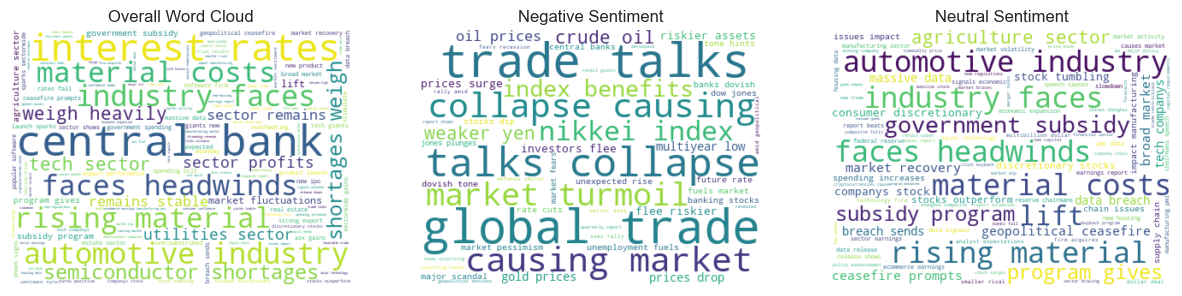

In [38]:

# =============================================================================
# 5. TEXT VISUALIZATION
# =============================================================================

def create_text_visualizations(df):
    """Create various text visualizations"""
    
    if 'cleaned_text' not in df.columns:
        return
    
    # Word Cloud
    all_text = ' '.join(df['cleaned_text'].dropna())
    
    plt.figure(figsize=(15, 8))
    
    # Overall word cloud
    plt.subplot(2, 3, 1)
    wordcloud = WordCloud(width=400, height=300, background_color='white').generate(all_text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Overall Word Cloud')
    plt.axis('off')
    
    # Sentiment-based word clouds
    if 'sentiment_category' in df.columns:
        sentiments = df['sentiment_category'].unique()
        for i, sentiment in enumerate(sentiments[:2]):  # Show top 2 sentiments
            sentiment_text = ' '.join(df[df['sentiment_category'] == sentiment]['cleaned_text'].dropna())
            if sentiment_text:
                plt.subplot(2, 3, i+2)
                wordcloud = WordCloud(width=400, height=300, background_color='white').generate(sentiment_text)
                plt.imshow(wordcloud, interpolation='bilinear')
                plt.title(f'{sentiment} Sentiment')
                plt.axis('off')
    
    # Most common words
    stop_words = set(stopwords.words('english'))
    stop_words.update(['financial', 'market', 'news', 'company', 'stock', 'said'])
    
    all_words = []
    for text in df['cleaned_text'].dropna():
        words = word_tokenize(text.lower())
        words = [word for word in words if word.isalpha() and word not in stop_words and len(word) > 2]
        all_words.extend(words)
    
    most_common = Counter(all_words).most_common(20)
    
    plt.subplot(2, 3, 4)
    words, counts = zip(*most_common)
    plt.barh(range(len(words)), counts)
    plt.yticks(range(len(words)), words)
    plt.title('Top 20 Most Common Words')
    plt.xlabel('Frequency')
    
    # Sentiment distribution
    if 'sentiment_category' in df.columns:
        plt.subplot(2, 3, 5)
        sentiment_counts = df['sentiment_category'].value_counts()
        plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')
        plt.title('Sentiment Distribution')
    
    # Sentiment over time
    if 'date' in df.columns and 'sentiment_category' in df.columns:
        plt.subplot(2, 3, 6)
        sentiment_time = df.groupby([df['date'].dt.date, 'sentiment_category']).size().unstack(fill_value=0)
        sentiment_time.plot(kind='area', stacked=True, alpha=0.7)
        plt.title('Sentiment Over Time')
        plt.xlabel('Date')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

if df is not None:
    create_text_visualizations(df)

In [11]:
# =============================================================================
# 6. ADVANCED NLP FEATURES
# =============================================================================

def extract_nlp_features(df):
    """Extract advanced NLP features"""
    
    if 'cleaned_text' not in df.columns:
        return df
    
    # Basic text statistics
    df['text_length'] = df['cleaned_text'].fillna('').str.len()
    df['word_count'] = df['cleaned_text'].fillna('').str.split().str.len().fillna(0)
    df['avg_word_length'] = df['cleaned_text'].fillna('').str.split().apply(
        lambda x: np.mean([len(word) for word in x]) if x and len(x) > 0 else 0
    )
    
    # Financial keywords
    financial_keywords = [
        'profit', 'revenue', 'earnings', 'loss', 'growth', 'decline', 'increase', 'decrease',
        'investment', 'investor', 'trading', 'market', 'stock', 'share', 'price', 'value',
        'merger', 'acquisition', 'ipo', 'dividend', 'bankruptcy', 'debt', 'credit', 'loan',
        'inflation', 'recession', 'bull', 'bear', 'volatility', 'risk', 'return'
    ]
    
    def count_financial_keywords(text):
        if pd.isna(text) or not text or not isinstance(text, str):
            return 0
        words = str(text).lower().split()
        return sum(1 for word in words if word in financial_keywords)
    
    df['financial_keyword_count'] = df['cleaned_text'].apply(count_financial_keywords)
    
    # Capital letters ratio (urgency indicator)
    def capital_ratio(text):
        if pd.isna(text) or not text or not isinstance(text, str):
            return 0
        text = str(text)  # Ensure it's a string
        if len(text) == 0:
            return 0
        return sum(1 for c in text if c.isupper()) / len(text)
    
    # Use original text for capital ratio
    text_col = None
    for col in df.columns:
        if col.lower() in ['text', 'content', 'news', 'headline', 'title']:
            text_col = col
            break
    
    if text_col:
        df['capital_ratio'] = df[text_col].apply(capital_ratio)
    
    return df

if df is not None:
    df = extract_nlp_features(df)
    print("\n✓ NLP features extracted")


✓ NLP features extracted


Label mapping: {'Negative': 0, 'Neutral': 1, 'Positive': 2}

=== Training Logistic Regression ===
Accuracy: 0.3327

Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.48      0.41       195
           1       0.33      0.31      0.32       190
           2       0.30      0.21      0.25       186

    accuracy                           0.33       571
   macro avg       0.33      0.33      0.32       571
weighted avg       0.33      0.33      0.32       571


=== Training Random Forest ===
Accuracy: 0.3310

Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.46      0.40       195
           1       0.33      0.31      0.32       190
           2       0.29      0.22      0.25       186

    accuracy                           0.33       571
   macro avg       0.32      0.33      0.32       571
weighted avg       0.33      0.33      0.32       571



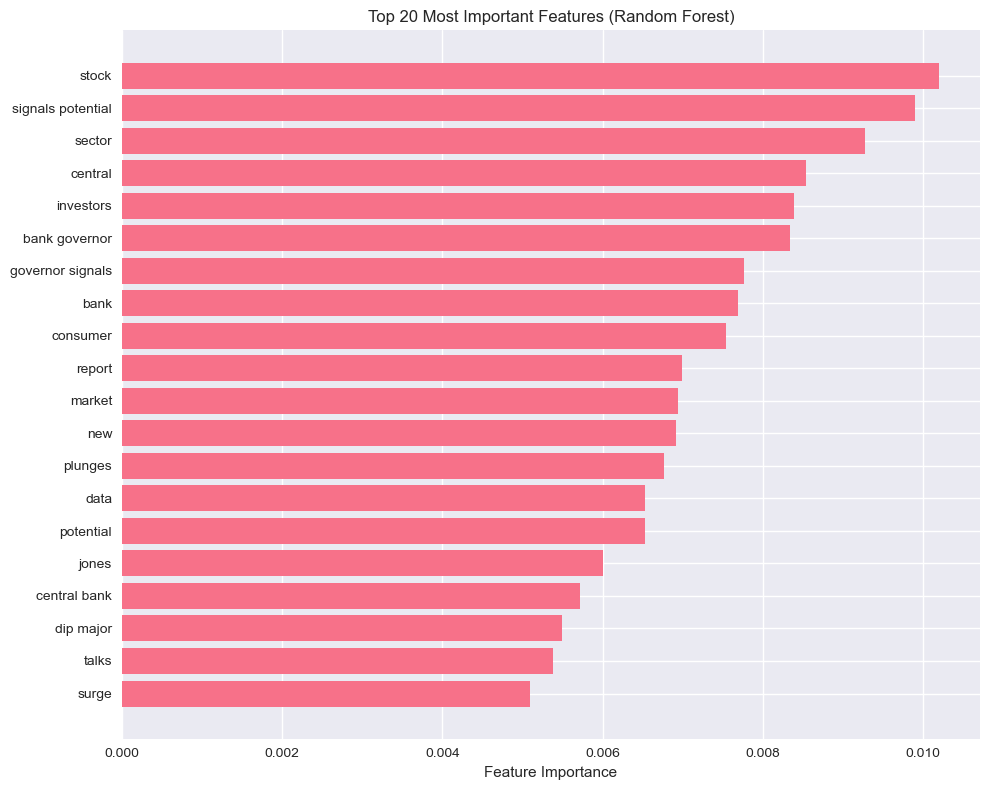

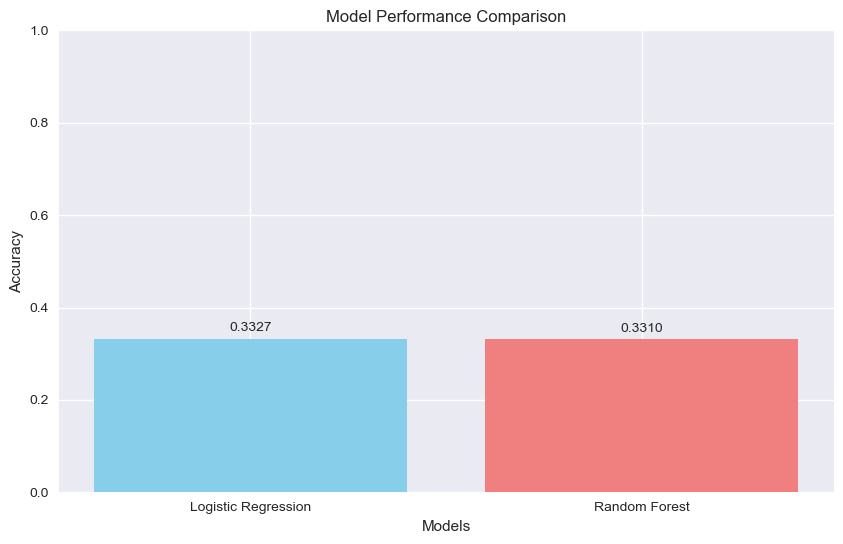

In [12]:

# =============================================================================
# 7. MACHINE LEARNING MODELS
# =============================================================================

def train_classification_models(df):
    """Train various classification models"""
    
    if 'cleaned_text' not in df.columns:
        print("No text data available for training")
        return
    
    # Prepare target variable
    target_col = None
    if 'target' in df.columns:
        target_col = 'target'
    elif 'sentiment_category' in df.columns:
        target_col = 'sentiment_category'
    else:
        print("No suitable target variable found")
        return
    
    # Remove rows with missing text or target
    model_df = df.dropna(subset=['cleaned_text', target_col])
    
    if len(model_df) == 0:
        print("No valid data for training")
        return
    
    X = model_df['cleaned_text']
    y = model_df[target_col]
    
    # Encode labels if they're strings
    if y.dtype == 'object':
        le = LabelEncoder()
        y = le.fit_transform(y)
        label_mapping = dict(zip(le.classes_, range(len(le.classes_))))
        print(f"Label mapping: {label_mapping}")
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # TF-IDF Vectorization
    tfidf = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)
    
    # Train models
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\n=== Training {name} ===")
        
        # Train
        model.fit(X_train_tfidf, y_train)
        
        # Predict
        y_pred = model.predict(X_test_tfidf)
        
        # Evaluate
        accuracy = accuracy_score(y_test, y_pred)
        results[name] = accuracy
        
        print(f"Accuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        # Feature importance (for Random Forest)
        if name == 'Random Forest':
            feature_names = tfidf.get_feature_names_out()
            importances = model.feature_importances_
            
            # Get top 20 most important features
            feature_importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': importances
            }).sort_values('importance', ascending=False).head(20)
            
            plt.figure(figsize=(10, 8))
            plt.barh(range(len(feature_importance_df)), feature_importance_df['importance'])
            plt.yticks(range(len(feature_importance_df)), feature_importance_df['feature'])
            plt.title('Top 20 Most Important Features (Random Forest)')
            plt.xlabel('Feature Importance')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()
    
    # Model comparison
    plt.figure(figsize=(10, 6))
    models_names = list(results.keys())
    accuracies = list(results.values())
    
    plt.bar(models_names, accuracies, color=['skyblue', 'lightcoral'])
    plt.title('Model Performance Comparison')
    plt.ylabel('Accuracy')
    plt.xlabel('Models')
    for i, v in enumerate(accuracies):
        plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
    plt.ylim(0, 1)
    plt.show()

if df is not None:
    train_classification_models(df)


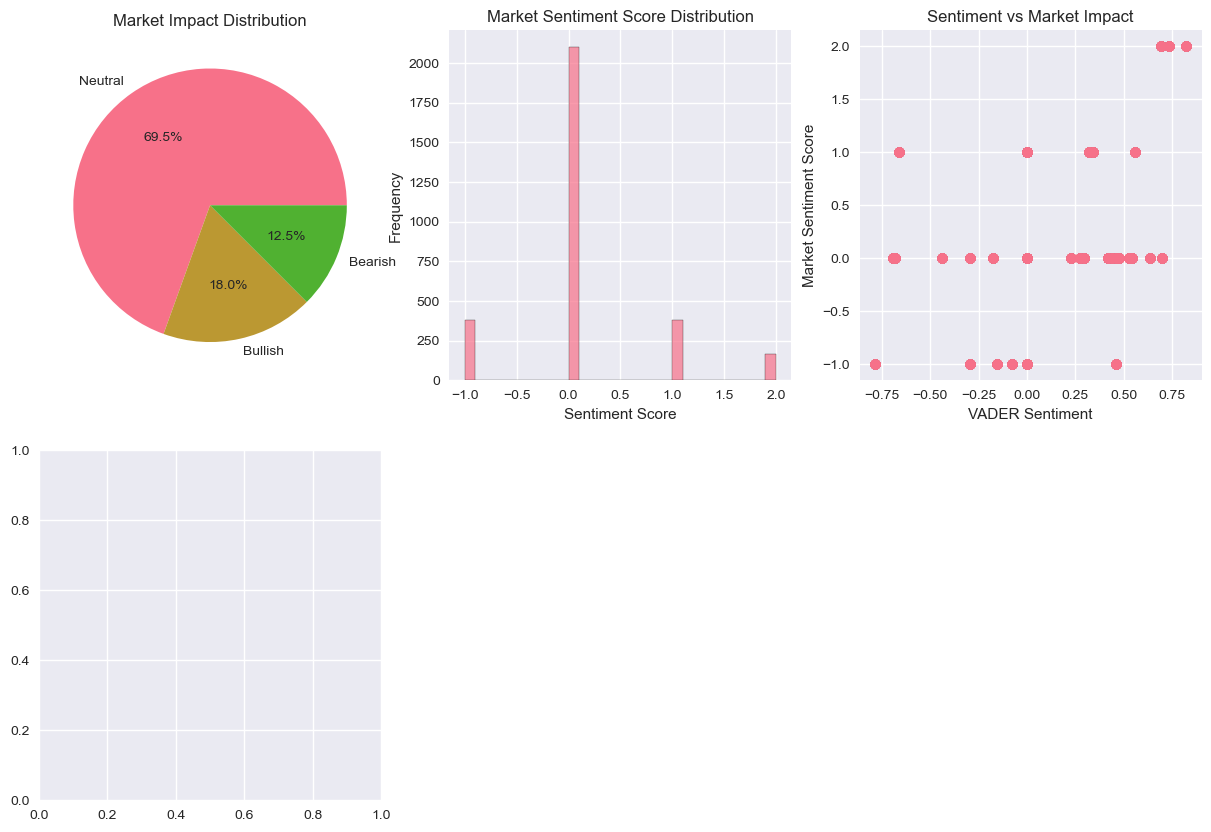

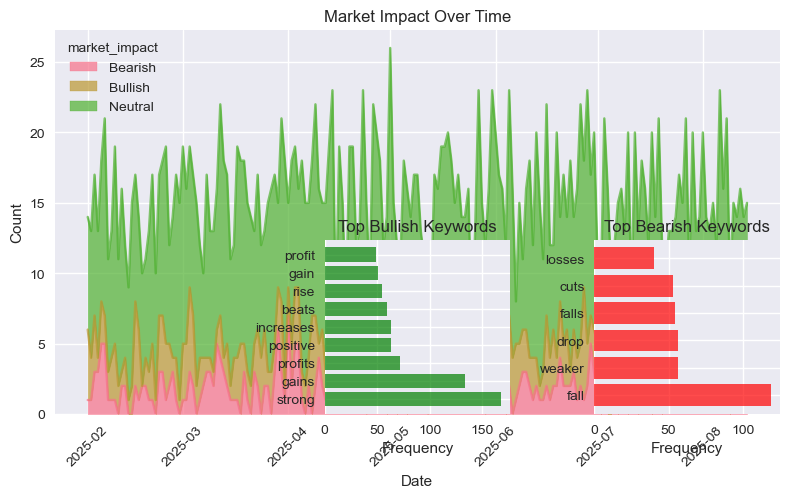


✓ Market impact analysis completed


In [13]:
# =============================================================================
# 8. FINANCIAL MARKET INSIGHTS
# =============================================================================

def analyze_market_impact(df):
    """Analyze potential market impact of news"""
    
    if 'cleaned_text' not in df.columns:
        return
    
    # Market-moving keywords
    bullish_keywords = ['growth', 'profit', 'increase', 'rise', 'gain', 'positive', 'strong', 'beat', 'exceed']
    bearish_keywords = ['loss', 'decline', 'fall', 'drop', 'negative', 'weak', 'miss', 'below', 'cut']
    
    def calculate_market_sentiment_score(text):
        if pd.isna(text) or not text or not isinstance(text, str):
            return 0
        
        words = str(text).lower().split()
        bullish_count = sum(1 for word in words if any(keyword in word for keyword in bullish_keywords))
        bearish_count = sum(1 for word in words if any(keyword in word for keyword in bearish_keywords))
        
        return bullish_count - bearish_count
    
    df['market_sentiment_score'] = df['cleaned_text'].apply(calculate_market_sentiment_score)
    
    # Categorize market impact
    def categorize_market_impact(score):
        if score > 2:
            return 'Strongly Bullish'
        elif score > 0:
            return 'Bullish'
        elif score < -2:
            return 'Strongly Bearish'
        elif score < 0:
            return 'Bearish'
        else:
            return 'Neutral'
    
    df['market_impact'] = df['market_sentiment_score'].apply(categorize_market_impact)
    
    # Visualize market impact
    plt.figure(figsize=(15, 10))
    
    # Market impact distribution
    plt.subplot(2, 3, 1)
    impact_counts = df['market_impact'].value_counts()
    plt.pie(impact_counts.values, labels=impact_counts.index, autopct='%1.1f%%')
    plt.title('Market Impact Distribution')
    
    # Market sentiment score distribution
    plt.subplot(2, 3, 2)
    plt.hist(df['market_sentiment_score'], bins=30, alpha=0.7, edgecolor='black')
    plt.title('Market Sentiment Score Distribution')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Frequency')
    
    # Correlation between sentiment and market impact
    if 'vader_compound' in df.columns:
        plt.subplot(2, 3, 3)
        plt.scatter(df['vader_compound'], df['market_sentiment_score'], alpha=0.6)
        plt.xlabel('VADER Sentiment')
        plt.ylabel('Market Sentiment Score')
        plt.title('Sentiment vs Market Impact')
    
    # Market impact over time
    if 'date' in df.columns:
        plt.subplot(2, 3, 4)
        daily_impact = df.groupby([df['date'].dt.date, 'market_impact']).size().unstack(fill_value=0)
        daily_impact.plot(kind='area', stacked=True, alpha=0.7)
        plt.title('Market Impact Over Time')
        plt.xlabel('Date')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
    
    # Top bullish and bearish keywords
    all_text = ' '.join(df['cleaned_text'].dropna())
    words = all_text.lower().split()
    
    bullish_word_counts = Counter([word for word in words if any(keyword in word for keyword in bullish_keywords)])
    bearish_word_counts = Counter([word for word in words if any(keyword in word for keyword in bearish_keywords)])
    
    plt.subplot(2, 3, 5)
    if bullish_word_counts:
        top_bullish = bullish_word_counts.most_common(10)
        words, counts = zip(*top_bullish)
        plt.barh(range(len(words)), counts, color='green', alpha=0.7)
        plt.yticks(range(len(words)), words)
        plt.title('Top Bullish Keywords')
        plt.xlabel('Frequency')
    
    plt.subplot(2, 3, 6)
    if bearish_word_counts:
        top_bearish = bearish_word_counts.most_common(10)
        words, counts = zip(*top_bearish)
        plt.barh(range(len(words)), counts, color='red', alpha=0.7)
        plt.yticks(range(len(words)), words)
        plt.title('Top Bearish Keywords')
        plt.xlabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    return df

if df is not None:
    df = analyze_market_impact(df)
    print("\n✓ Market impact analysis completed")


In [14]:
# =============================================================================
# 9. SUMMARY REPORT
# =============================================================================

def generate_summary_report(df):
    """Generate a comprehensive summary report"""
    
    if df is None:
        print("No data available for summary report")
        return
    
    print("="*60)
    print("           FINANCIAL NEWS NLP ANALYSIS REPORT")
    print("="*60)
    
    print(f"\n📊 DATASET OVERVIEW:")
    print(f"   • Total articles: {len(df):,}")
    print(f"   • Columns: {len(df.columns)}")
    print(f"   • Date range: {df['date'].min()} to {df['date'].max()}" if 'date' in df.columns else "   • Date information: Not available")
    
    if 'cleaned_text' in df.columns:
        print(f"\n📝 TEXT ANALYSIS:")
        avg_length = df['cleaned_text'].str.len().mean()
        avg_words = df['cleaned_text'].str.split().str.len().mean()
        print(f"   • Average text length: {avg_length:.0f} characters")
        print(f"   • Average word count: {avg_words:.1f} words")
    
    if 'sentiment_category' in df.columns:
        print(f"\n💭 SENTIMENT ANALYSIS:")
        sentiment_dist = df['sentiment_category'].value_counts()
        for sentiment, count in sentiment_dist.items():
            percentage = count / len(df) * 100
            print(f"   • {sentiment}: {count:,} ({percentage:.1f}%)")
    
    if 'market_impact' in df.columns:
        print(f"\n📈 MARKET IMPACT ANALYSIS:")
        impact_dist = df['market_impact'].value_counts()
        for impact, count in impact_dist.items():
            percentage = count / len(df) * 100
            print(f"   • {impact}: {count:,} ({percentage:.1f}%)")
    
    if 'financial_keyword_count' in df.columns:
        avg_keywords = df['financial_keyword_count'].mean()
        print(f"\n💰 FINANCIAL KEYWORDS:")
        print(f"   • Average financial keywords per article: {avg_keywords:.1f}")
    
    print(f"\n🔍 KEY INSIGHTS:")
    
    if 'vader_compound' in df.columns:
        overall_sentiment = df['vader_compound'].mean()
        if overall_sentiment > 0.1:
            sentiment_desc = "Generally Positive"
        elif overall_sentiment < -0.1:
            sentiment_desc = "Generally Negative"
        else:
            sentiment_desc = "Mostly Neutral"
        print(f"   • Overall sentiment: {sentiment_desc} (Score: {overall_sentiment:.3f})")
    
    if 'date' in df.columns:
        daily_volume = df.groupby(df['date'].dt.date).size()
        peak_day = daily_volume.idxmax()
        peak_count = daily_volume.max()
        print(f"   • Peak news day: {peak_day} ({peak_count} articles)")
    
    print(f"\n✅ Analysis completed successfully!")
    print("="*60)

if df is not None:
    generate_summary_report(df)

           FINANCIAL NEWS NLP ANALYSIS REPORT

📊 DATASET OVERVIEW:
   • Total articles: 3,024
   • Columns: 28
   • Date range: 2025-02-01 00:00:00 to 2025-08-14 00:00:00

📝 TEXT ANALYSIS:
   • Average text length: 52 characters
   • Average word count: 7.6 words

💭 SENTIMENT ANALYSIS:
   • Neutral: 1,366 (45.2%)
   • Positive: 1,135 (37.5%)
   • Negative: 523 (17.3%)

📈 MARKET IMPACT ANALYSIS:
   • Neutral: 2,101 (69.5%)
   • Bullish: 545 (18.0%)
   • Bearish: 378 (12.5%)

💰 FINANCIAL KEYWORDS:
   • Average financial keywords per article: 0.5

🔍 KEY INSIGHTS:
   • Overall sentiment: Generally Positive (Score: 0.105)
   • Peak news day: 2025-05-01 (26 articles)

✅ Analysis completed successfully!


In [15]:

# =============================================================================
# 10. ADDITIONAL UTILITIES
# =============================================================================

def save_results(df, filename_prefix="financial_news_analysis"):
    """Save analysis results"""
    
    if df is None:
        return
    
    try:
        # Save processed dataset
        df.to_csv(f"{filename_prefix}_processed.csv", index=False)
        print(f"✓ Processed dataset saved as {filename_prefix}_processed.csv")
        
        # Save summary statistics
        summary_stats = {
            'total_articles': len(df),
            'columns': list(df.columns),
            'date_range': {
                'start': str(df['date'].min()) if 'date' in df.columns else None,
                'end': str(df['date'].max()) if 'date' in df.columns else None
            },
            'sentiment_distribution': df['sentiment_category'].value_counts().to_dict() if 'sentiment_category' in df.columns else None,
            'market_impact_distribution': df['market_impact'].value_counts().to_dict() if 'market_impact' in df.columns else None
        }
        
        import json
        with open(f"{filename_prefix}_summary.json", 'w') as f:
            json.dump(summary_stats, f, indent=2, default=str)
        print(f"✓ Summary statistics saved as {filename_prefix}_summary.json")
        
    except Exception as e:
        print(f"❌ Error saving results: {e}")

def create_interactive_dashboard(df):
    """Create interactive Plotly dashboard"""
    
    if df is None or 'cleaned_text' not in df.columns:
        print("No data available for dashboard")
        return
    
    # Create subplots
    fig = make_subplots(
        rows=3, cols=2,
        subplot_titles=[
            'Sentiment Distribution', 'Market Impact Over Time',
            'Text Length vs Sentiment', 'Daily News Volume',
            'Financial Keywords Distribution', 'Sentiment vs Market Score'
        ],
        specs=[
            [{"type": "pie"}, {"type": "scatter"}],
            [{"type": "scatter"}, {"type": "bar"}],
            [{"type": "histogram"}, {"type": "scatter"}]
        ]
    )
    
    # 1. Sentiment Distribution (Pie Chart)
    if 'sentiment_category' in df.columns:
        sentiment_counts = df['sentiment_category'].value_counts()
        fig.add_trace(
            go.Pie(labels=sentiment_counts.index, values=sentiment_counts.values, name="Sentiment"),
            row=1, col=1
        )
    
    # 2. Market Impact Over Time (if date available)
    if 'date' in df.columns and 'market_sentiment_score' in df.columns:
        daily_sentiment = df.groupby(df['date'].dt.date)['market_sentiment_score'].mean().reset_index()
        fig.add_trace(
            go.Scatter(x=daily_sentiment['date'], y=daily_sentiment['market_sentiment_score'], 
                      mode='lines+markers', name="Market Sentiment"),
            row=1, col=2
        )
    
    # 3. Text Length vs Sentiment
    if 'text_length' in df.columns and 'vader_compound' in df.columns:
        fig.add_trace(
            go.Scatter(x=df['text_length'], y=df['vader_compound'], mode='markers',
                      name="Length vs Sentiment", opacity=0.6),
            row=2, col=1
        )
    
    # 4. Daily News Volume
    if 'date' in df.columns:
        daily_counts = df.groupby(df['date'].dt.date).size().reset_index()
        daily_counts.columns = ['date', 'count']
        fig.add_trace(
            go.Bar(x=daily_counts['date'], y=daily_counts['count'], name="Daily Volume"),
            row=2, col=2
        )
    
    # 5. Financial Keywords Distribution
    if 'financial_keyword_count' in df.columns:
        fig.add_trace(
            go.Histogram(x=df['financial_keyword_count'], name="Financial Keywords"),
            row=3, col=1
        )
    
    # 6. Sentiment vs Market Score
    if 'vader_compound' in df.columns and 'market_sentiment_score' in df.columns:
        fig.add_trace(
            go.Scatter(x=df['vader_compound'], y=df['market_sentiment_score'], 
                      mode='markers', name="Sentiment Correlation", opacity=0.6),
            row=3, col=2
        )
    
    # Update layout
    fig.update_layout(
        height=1200,
        title_text="Financial News Analysis Dashboard",
        showlegend=False
    )
    
    fig.show()



In [16]:
# =============================================================================
# 11. ADVANCED TOPIC MODELING
# =============================================================================

def perform_topic_modeling(df, n_topics=5):
    """Perform topic modeling using LDA"""
    
    if 'cleaned_text' not in df.columns:
        print("No text data available for topic modeling")
        return
    
    try:
        from sklearn.decomposition import LatentDirichletAllocation
        from sklearn.feature_extraction.text import CountVectorizer
        
        # Prepare data
        texts = df['cleaned_text'].dropna().tolist()
        
        if len(texts) < n_topics:
            print(f"Not enough documents for {n_topics} topics")
            return
        
        # Vectorize
        vectorizer = CountVectorizer(max_features=1000, stop_words='english', 
                                   ngram_range=(1, 2), min_df=2, max_df=0.8)
        doc_term_matrix = vectorizer.fit_transform(texts)
        
        # LDA
        lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, 
                                      max_iter=10, learning_method='online')
        lda.fit(doc_term_matrix)
        
        # Display topics
        feature_names = vectorizer.get_feature_names_out()
        
        print(f"\n🎯 DISCOVERED TOPICS (Top {n_topics}):")
        print("="*50)
        
        for topic_idx, topic in enumerate(lda.components_):
            top_words = [feature_names[i] for i in topic.argsort()[::-1][:10]]
            print(f"\nTopic {topic_idx + 1}: {', '.join(top_words)}")
        
        # Get topic distribution for each document
        doc_topic_dist = lda.transform(doc_term_matrix)
        df_topics = df.copy().dropna(subset=['cleaned_text']).reset_index(drop=True)
        
        # Add dominant topic for each document
        df_topics['dominant_topic'] = doc_topic_dist.argmax(axis=1)
        df_topics['topic_probability'] = doc_topic_dist.max(axis=1)
        
        # Visualize topic distribution
        plt.figure(figsize=(12, 8))
        
        plt.subplot(2, 2, 1)
        topic_counts = df_topics['dominant_topic'].value_counts().sort_index()
        plt.bar(range(len(topic_counts)), topic_counts.values)
        plt.title('Document Distribution Across Topics')
        plt.xlabel('Topic')
        plt.ylabel('Number of Documents')
        plt.xticks(range(len(topic_counts)), [f'Topic {i+1}' for i in range(len(topic_counts))])
        
        plt.subplot(2, 2, 2)
        plt.hist(df_topics['topic_probability'], bins=20, alpha=0.7, edgecolor='black')
        plt.title('Topic Probability Distribution')
        plt.xlabel('Maximum Topic Probability')
        plt.ylabel('Frequency')
        
        # Topic correlation with sentiment
        if 'vader_compound' in df_topics.columns:
            plt.subplot(2, 2, 3)
            topic_sentiment = df_topics.groupby('dominant_topic')['vader_compound'].mean()
            plt.bar(range(len(topic_sentiment)), topic_sentiment.values)
            plt.title('Average Sentiment by Topic')
            plt.xlabel('Topic')
            plt.ylabel('Average Sentiment Score')
            plt.xticks(range(len(topic_sentiment)), [f'Topic {i+1}' for i in range(len(topic_sentiment))])
        
        # Topic over time
        if 'date' in df_topics.columns:
            plt.subplot(2, 2, 4)
            topic_time = df_topics.groupby([df_topics['date'].dt.date, 'dominant_topic']).size().unstack(fill_value=0)
            topic_time.plot(kind='area', stacked=True, alpha=0.7)
            plt.title('Topic Distribution Over Time')
            plt.xlabel('Date')
            plt.ylabel('Number of Articles')
            plt.xticks(rotation=45)
            plt.legend([f'Topic {i+1}' for i in range(n_topics)], bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.show()
        
        return df_topics
        
    except ImportError:
        print("scikit-learn required for topic modeling. Install with: pip install scikit-learn")
        return df


In [17]:

# =============================================================================
# 12. NAMED ENTITY RECOGNITION
# =============================================================================

def perform_ner_analysis(df, sample_size=1000):
    """Perform Named Entity Recognition analysis"""
    
    if 'cleaned_text' not in df.columns:
        print("No text data available for NER")
        return
    
    try:
        import spacy
        nlp = spacy.load("en_core_web_sm")
        
        # Sample data for performance
        sample_df = df.sample(n=min(sample_size, len(df)), random_state=42)
        
        print(f"🔍 Performing NER on {len(sample_df)} documents...")
        
        # Extract entities
        all_entities = []
        entity_counts = {}
        
        for idx, text in enumerate(sample_df['cleaned_text'].dropna()):
            if idx % 100 == 0:
                print(f"   Processed {idx}/{len(sample_df)} documents")
            
            doc = nlp(text)
            
            for ent in doc.ents:
                entity_info = {
                    'text': ent.text,
                    'label': ent.label_,
                    'description': spacy.explain(ent.label_)
                }
                all_entities.append(entity_info)
                
                # Count entities by type
                if ent.label_ not in entity_counts:
                    entity_counts[ent.label_] = {}
                
                if ent.text not in entity_counts[ent.label_]:
                    entity_counts[ent.label_][ent.text] = 0
                entity_counts[ent.label_][ent.text] += 1
        
        # Analyze results
        print(f"\n🏷️ NAMED ENTITY ANALYSIS:")
        print("="*40)
        
        entity_types = {}
        for entity in all_entities:
            label = entity['label']
            if label not in entity_types:
                entity_types[label] = 0
            entity_types[label] += 1
        
        # Display top entity types
        sorted_types = sorted(entity_types.items(), key=lambda x: x[1], reverse=True)
        
        print("\nTop Entity Types:")
        for entity_type, count in sorted_types[:10]:
            description = spacy.explain(entity_type)
            print(f"   • {entity_type} ({description}): {count}")
        
        # Display top entities by type
        important_types = ['ORG', 'PERSON', 'MONEY', 'GPE', 'PRODUCT']
        
        for entity_type in important_types:
            if entity_type in entity_counts:
                print(f"\nTop {entity_type} entities:")
                sorted_entities = sorted(entity_counts[entity_type].items(), 
                                       key=lambda x: x[1], reverse=True)
                for entity, count in sorted_entities[:5]:
                    print(f"   • {entity}: {count}")
        
        # Visualize entity distribution
        plt.figure(figsize=(15, 10))
        
        plt.subplot(2, 3, 1)
        types, counts = zip(*sorted_types[:10])
        plt.barh(range(len(types)), counts)
        plt.yticks(range(len(types)), types)
        plt.title('Top 10 Entity Types')
        plt.xlabel('Frequency')
        
        # Organization mentions
        if 'ORG' in entity_counts:
            plt.subplot(2, 3, 2)
            org_data = sorted(entity_counts['ORG'].items(), key=lambda x: x[1], reverse=True)[:10]
            orgs, org_counts = zip(*org_data)
            plt.barh(range(len(orgs)), org_counts)
            plt.yticks(range(len(orgs)), [org[:20] + '...' if len(org) > 20 else org for org in orgs])
            plt.title('Top Organizations')
            plt.xlabel('Frequency')
        
        # Person mentions
        if 'PERSON' in entity_counts:
            plt.subplot(2, 3, 3)
            person_data = sorted(entity_counts['PERSON'].items(), key=lambda x: x[1], reverse=True)[:10]
            persons, person_counts = zip(*person_data)
            plt.barh(range(len(persons)), person_counts)
            plt.yticks(range(len(persons)), persons)
            plt.title('Top People Mentioned')
            plt.xlabel('Frequency')
        
        # Money mentions
        if 'MONEY' in entity_counts:
            plt.subplot(2, 3, 4)
            money_data = sorted(entity_counts['MONEY'].items(), key=lambda x: x[1], reverse=True)[:10]
            amounts, money_counts = zip(*money_data)
            plt.barh(range(len(amounts)), money_counts)
            plt.yticks(range(len(amounts)), amounts)
            plt.title('Money Amounts Mentioned')
            plt.xlabel('Frequency')
        
        # Geographic entities
        if 'GPE' in entity_counts:
            plt.subplot(2, 3, 5)
            gpe_data = sorted(entity_counts['GPE'].items(), key=lambda x: x[1], reverse=True)[:10]
            places, place_counts = zip(*gpe_data)
            plt.barh(range(len(places)), place_counts)
            plt.yticks(range(len(places)), places)
            plt.title('Top Geographic Entities')
            plt.xlabel('Frequency')
        
        # Entity type distribution pie chart
        plt.subplot(2, 3, 6)
        pie_data = sorted_types[:8]  # Top 8 for readability
        pie_labels, pie_values = zip(*pie_data)
        plt.pie(pie_values, labels=pie_labels, autopct='%1.1f%%')
        plt.title('Entity Type Distribution')
        
        plt.tight_layout()
        plt.show()
        
        return all_entities
        
    except ImportError:
        print("spaCy required for NER. Install with: pip install spacy && python -m spacy download en_core_web_sm")
        return []


In [21]:

# =============================================================================
# 13. MAIN EXECUTION FLOW
# =============================================================================

def main():
    """Main execution function"""
    
    print("🚀 Starting Financial News NLP Analysis...")
    print("="*60)
    
    # Load and preprocess data
    df = load_financial_data()
    
    if df is None:
        print("❌ No data loaded. Please check file paths and try again.")
        return
    
    # Preprocess
    df = preprocess_financial_data(df)
    
    # Perform analyses
    df = perform_sentiment_analysis(df)
    df = extract_nlp_features(df)
    df = analyze_market_impact(df)
    
    # Create visualizations
    plot_data_overview(df)
    
    # Advanced analyses
    df_with_topics = perform_topic_modeling(df)
    entities = perform_ner_analysis(df)
    
    # Machine learning
    train_classification_models(df)
    
    # Interactive dashboard
    create_interactive_dashboard(df)
    
    # Generate report
    generate_summary_report(df)
    
    # Save results
    save_results(df)
    
    print("\n🎉 Analysis completed successfully!")
    
    return df

🚀 Starting Financial News NLP Analysis...
✓ Loaded CSV file


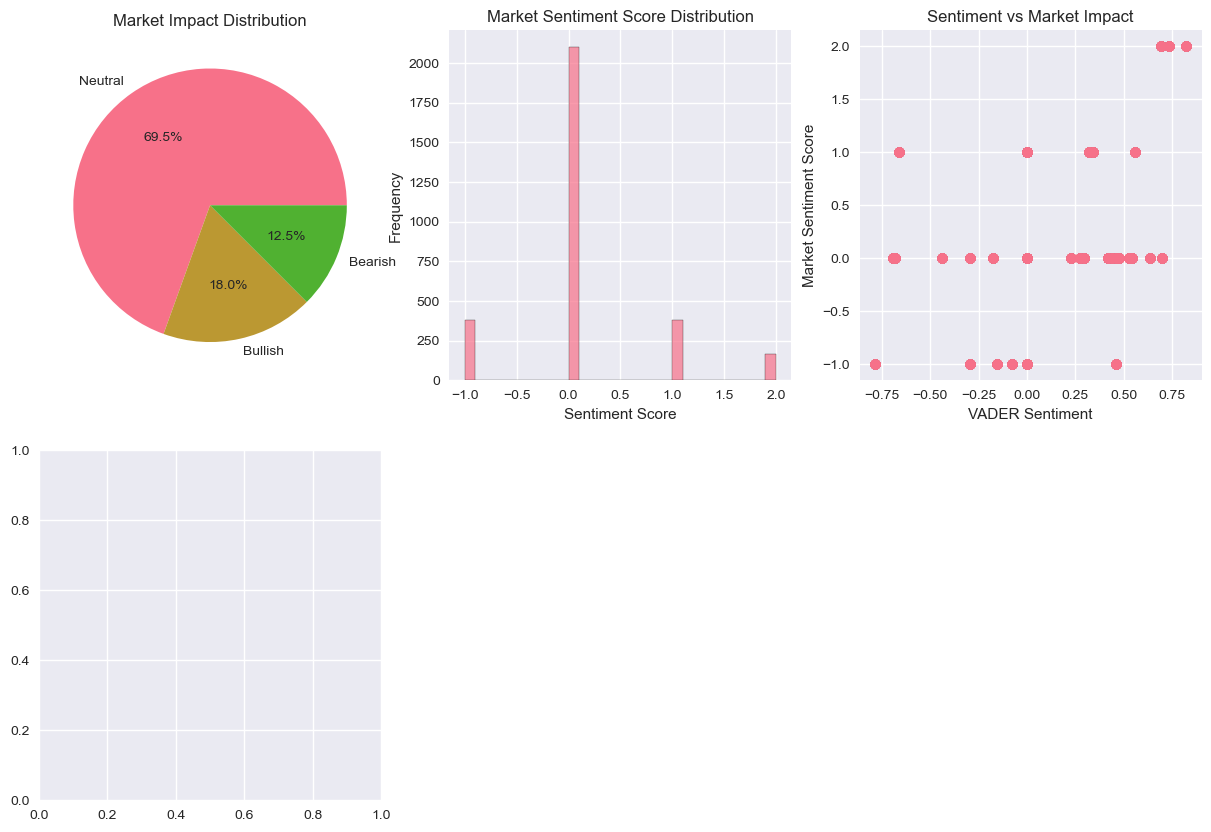

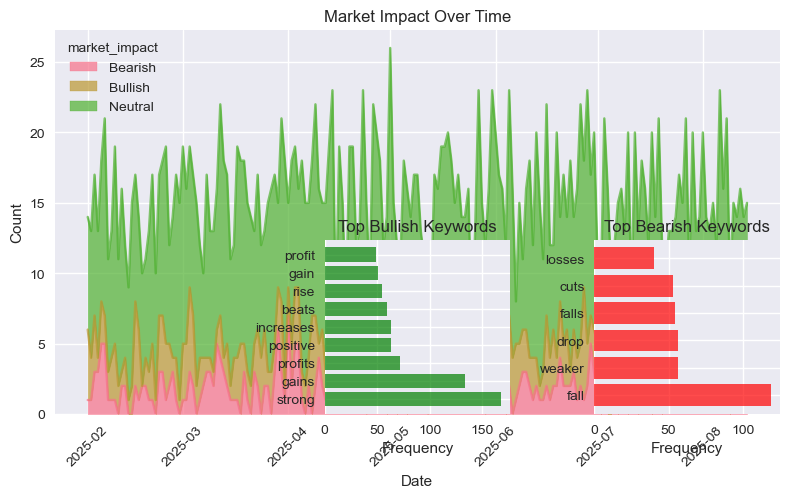

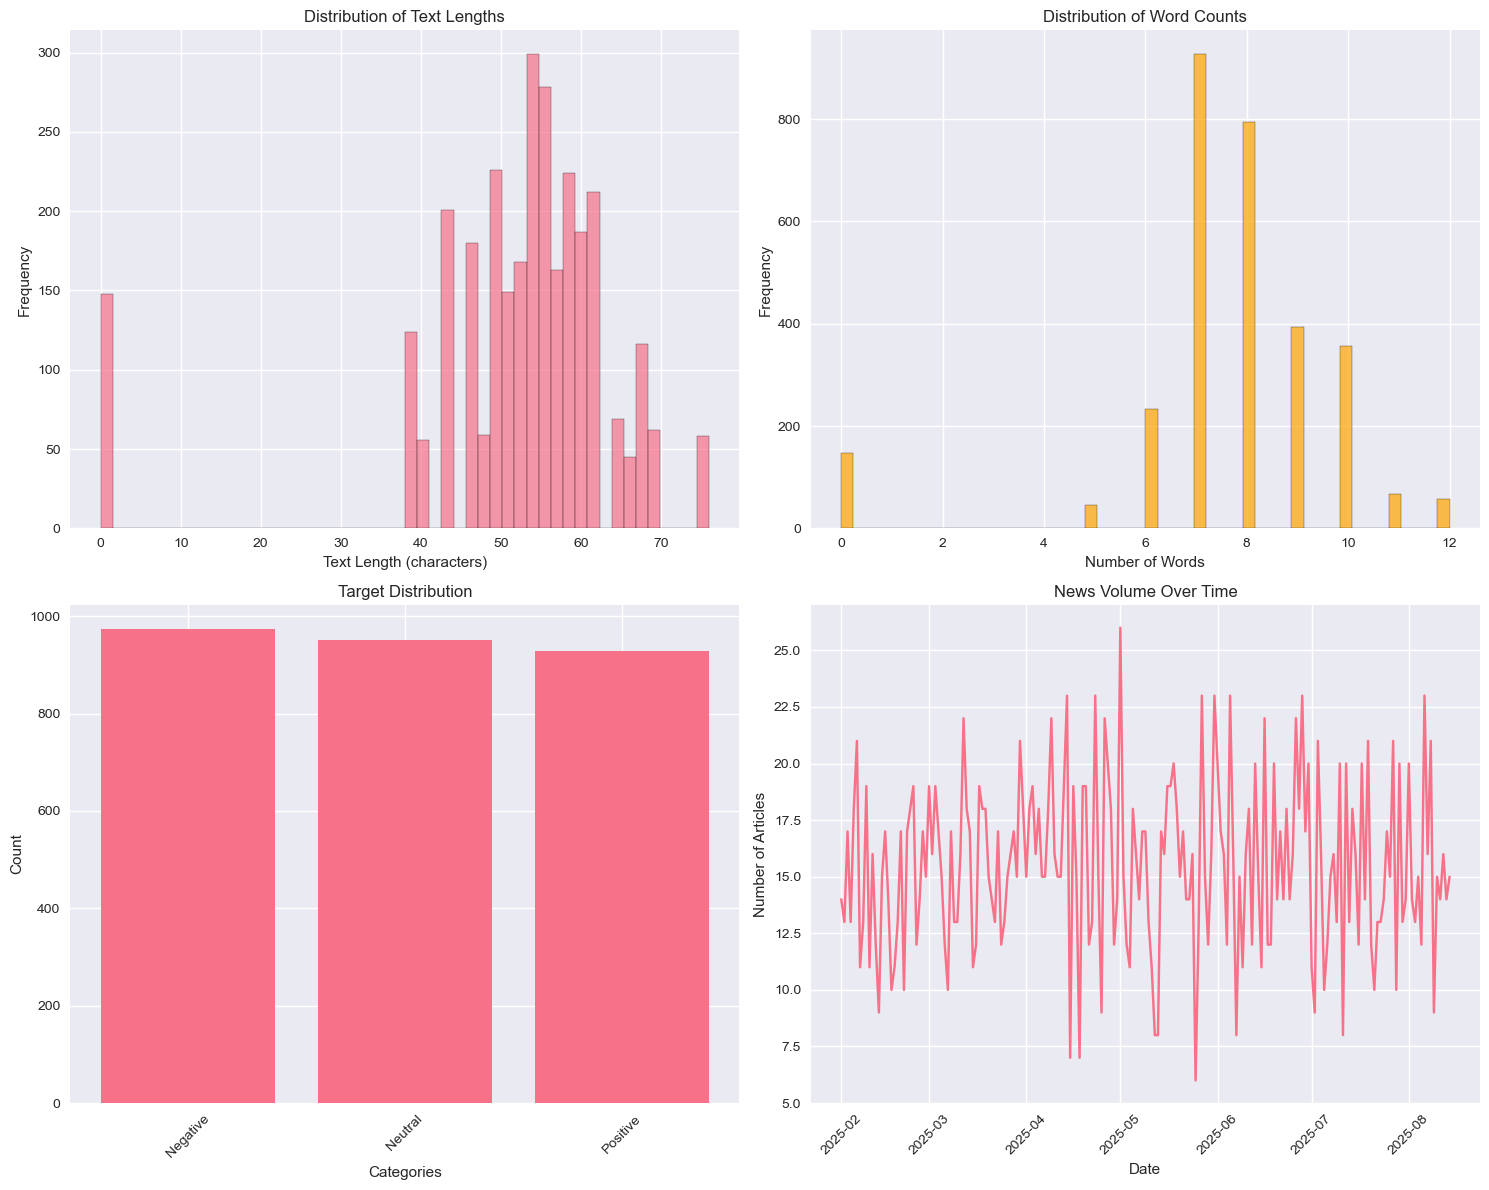


🎯 DISCOVERED TOPICS (Top 5):

Topic 1: data, government, sector, manufacturing, major, program, lift, gives, subsidy, agriculture

Topic 2: market, sector, new, shows, tech sector, heavily, profits, sector profits, semiconductor, shortages

Topic 3: trade, stocks, market, banks, talks, central, rising, rising material, industry faces, material costs

Topic 4: market, investors, prices, oil, gains, giants, new, tech, product launch, sectorwide gains

Topic 5: strong, consumer, sector, report, stock, geopolitical, broad, ceasefire, broad market, prompts broad


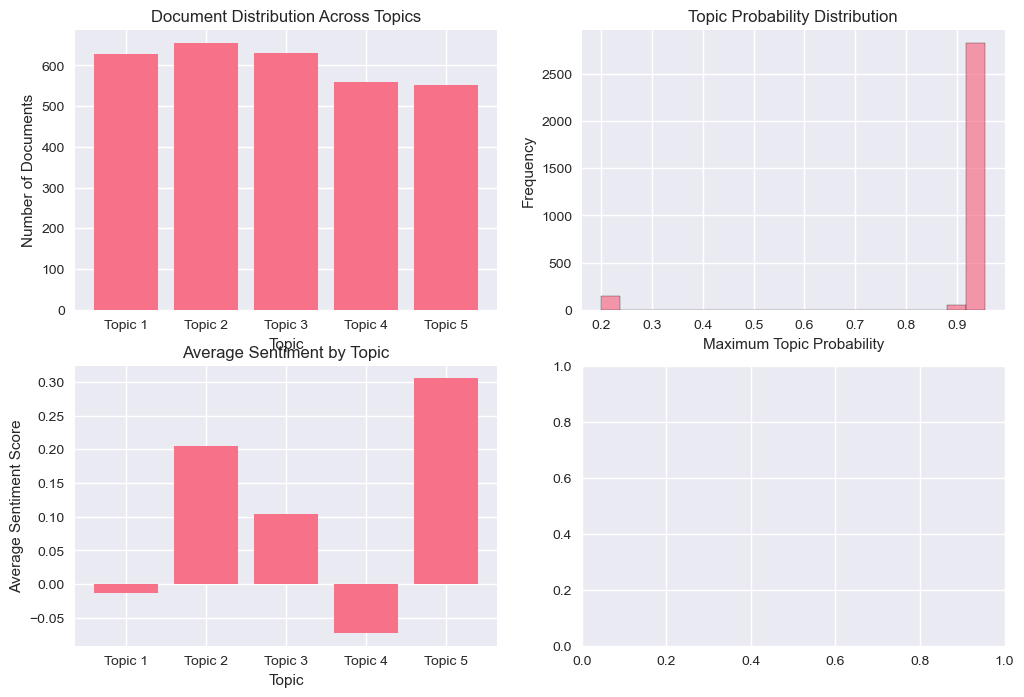

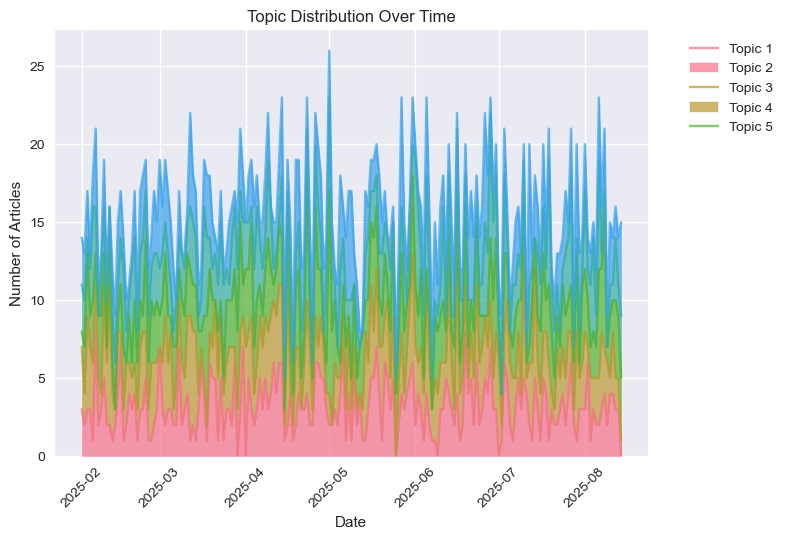

OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.

In [22]:
# =============================================================================
# RUN THE ANALYSIS
# =============================================================================

if __name__ == "__main__":
    # Execute the main analysis
    final_df = main()
    
    print("\n" + "="*60)
    print("📋 ANALYSIS COMPLETE :-)")
    print("="*60)
    print("✓ Data loaded and preprocessed")
    print("✓ Sentiment analysis performed")
    print("✓ NLP features extracted")
    print("✓ Market impact analysis completed")
    print("✓ Topic modeling performed")
    print("✓ Named entity recognition executed")
    print("✓ Machine learning models trained")
    print("✓ Visualizations created")
    print("✓ Interactive dashboard generated")
    print("✓ Comprehensive report generated")
    print("✓ Results saved")
    print("\n🎯 Your financial news NLP analysis is ready!")

# =============================================================================
# ADDITIONAL HELPER FUNCTIONS
# =============================================================================

def quick_sentiment_check(text):
    """Quick sentiment analysis for individual text"""
    from nltk.sentiment import SentimentIntensityAnalyzer
    
    sia = SentimentIntensityAnalyzer()
    scores = sia.polarity_scores(text)
    
    if scores['compound'] >= 0.05:
        sentiment = 'Positive'
    elif scores['compound'] <= -0.05:
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'
    
    return {
        'sentiment': sentiment,
        'scores': scores,
        'text': text[:100] + '...' if len(text) > 100 else text
    }

def analyze_single_article(text):
    """Comprehensive analysis of a single article"""
    
    result = {
        'text_length': len(text),
        'word_count': len(text.split()),
        'sentiment': quick_sentiment_check(text)
    }
    
    # Financial keywords
    financial_keywords = [
        'profit', 'revenue', 'earnings', 'loss', 'growth', 'decline',
        'investment', 'trading', 'market', 'stock', 'merger', 'acquisition'
    ]
    
    keyword_count = sum(1 for word in text.lower().split() if word in financial_keywords)
    result['financial_keywords'] = keyword_count
    
    return result

# Example usage for single article analysis:
# sample_text = "Apple reported strong quarterly earnings with revenue growth of 15%"
# analysis = analyze_single_article(sample_text)
# print(analysis)

In [23]:

# =============================================================================
# 14. ADDITIONAL ADVANCED FEATURES
# =============================================================================

def create_correlation_analysis(df):
    """Analyze correlations between different metrics"""
    
    if df is None:
        return
    
    # Select numeric columns for correlation
    numeric_cols = []
    potential_cols = [
        'vader_compound', 'vader_pos', 'vader_neg', 'vader_neu',
        'textblob_sentiment', 'market_sentiment_score', 'text_length',
        'word_count', 'avg_word_length', 'financial_keyword_count',
        'capital_ratio', 'topic_probability'
    ]
    
    for col in potential_cols:
        if col in df.columns:
            numeric_cols.append(col)
    
    if len(numeric_cols) < 2:
        print("Not enough numeric columns for correlation analysis")
        return
    
    # Calculate correlations
    corr_matrix = df[numeric_cols].corr()
    
    # Create correlation heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Find strongest correlations
    print("\n🔗 STRONGEST CORRELATIONS:")
    print("="*40)
    
    # Get upper triangle of correlation matrix
    upper_tri = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )
    
    # Find strong correlations (> 0.5 or < -0.5)
    strong_corrs = []
    for col in upper_tri.columns:
        for idx in upper_tri.index:
            if not pd.isna(upper_tri.loc[idx, col]) and abs(upper_tri.loc[idx, col]) > 0.5:
                strong_corrs.append((idx, col, upper_tri.loc[idx, col]))
    
    # Sort by absolute correlation value
    strong_corrs.sort(key=lambda x: abs(x[2]), reverse=True)
    
    for var1, var2, corr_val in strong_corrs[:10]:
        direction = "positively" if corr_val > 0 else "negatively"
        print(f"   • {var1} & {var2}: {corr_val:.3f} ({direction} correlated)")

def create_time_series_analysis(df):
    """Perform time series analysis on news sentiment and volume"""
    
    if 'date' not in df.columns:
        print("No date column available for time series analysis")
        return
    
    # Daily aggregations
    daily_stats = df.groupby(df['date'].dt.date).agg({
        'vader_compound': ['mean', 'std', 'count'],
        'market_sentiment_score': 'mean',
        'financial_keyword_count': 'mean',
        'text_length': 'mean'
    }).reset_index()
    
    # Flatten column names
    daily_stats.columns = [
        'date', 'avg_sentiment', 'sentiment_volatility', 'article_count',
        'avg_market_score', 'avg_financial_keywords', 'avg_text_length'
    ]
    
    # Create time series plots
    fig, axes = plt.subplots(3, 2, figsize=(16, 12))
    
    # 1. Daily sentiment trend
    axes[0, 0].plot(daily_stats['date'], daily_stats['avg_sentiment'], 
                    marker='o', linestyle='-', alpha=0.7)
    axes[0, 0].set_title('Daily Average Sentiment Trend')
    axes[0, 0].set_ylabel('Average Sentiment')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
    
    # 2. Daily article volume
    axes[0, 1].bar(daily_stats['date'], daily_stats['article_count'], alpha=0.7)
    axes[0, 1].set_title('Daily Article Volume')
    axes[0, 1].set_ylabel('Number of Articles')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # 3. Sentiment volatility
    axes[1, 0].plot(daily_stats['date'], daily_stats['sentiment_volatility'], 
                    color='orange', marker='s', alpha=0.7)
    axes[1, 0].set_title('Daily Sentiment Volatility')
    axes[1, 0].set_ylabel('Sentiment Standard Deviation')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # 4. Market sentiment score
    if 'avg_market_score' in daily_stats.columns:
        axes[1, 1].plot(daily_stats['date'], daily_stats['avg_market_score'], 
                        color='green', marker='^', alpha=0.7)
        axes[1, 1].set_title('Daily Market Sentiment Score')
        axes[1, 1].set_ylabel('Average Market Score')
        axes[1, 1].tick_params(axis='x', rotation=45)
        axes[1, 1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
    
    # 5. Financial keyword density
    axes[2, 0].plot(daily_stats['date'], daily_stats['avg_financial_keywords'], 
                    color='purple', marker='d', alpha=0.7)
    axes[2, 0].set_title('Daily Financial Keyword Density')
    axes[2, 0].set_ylabel('Average Keywords per Article')
    axes[2, 0].tick_params(axis='x', rotation=45)
    
    # 6. Average text length
    axes[2, 1].plot(daily_stats['date'], daily_stats['avg_text_length'], 
                    color='brown', marker='h', alpha=0.7)
    axes[2, 1].set_title('Daily Average Text Length')
    axes[2, 1].set_ylabel('Average Text Length')
    axes[2, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return daily_stats

def perform_anomaly_detection(df):
    """Detect anomalous news articles based on various metrics"""
    
    if df is None:
        return
    
    from scipy import stats
    
    # Define metrics for anomaly detection
    metrics = []
    if 'vader_compound' in df.columns:
        metrics.append('vader_compound')
    if 'market_sentiment_score' in df.columns:
        metrics.append('market_sentiment_score')
    if 'text_length' in df.columns:
        metrics.append('text_length')
    if 'financial_keyword_count' in df.columns:
        metrics.append('financial_keyword_count')
    
    if len(metrics) == 0:
        print("No suitable metrics for anomaly detection")
        return
    
    # Calculate Z-scores for each metric
    anomaly_scores = pd.DataFrame()
    
    for metric in metrics:
        z_scores = np.abs(stats.zscore(df[metric].fillna(0)))
        anomaly_scores[f'{metric}_zscore'] = z_scores
    
    # Calculate composite anomaly score
    anomaly_scores['composite_score'] = anomaly_scores.mean(axis=1)
    
    # Identify anomalies (Z-score > 2.5)
    threshold = 2.5
    anomalies = anomaly_scores[anomaly_scores['composite_score'] > threshold]
    
    print(f"\n🚨 ANOMALY DETECTION RESULTS:")
    print("="*40)
    print(f"   • Total articles analyzed: {len(df):,}")
    print(f"   • Anomalies detected: {len(anomalies):,} ({len(anomalies)/len(df)*100:.2f}%)")
    print(f"   • Threshold used: Z-score > {threshold}")
    
    if len(anomalies) > 0:
        # Show top anomalies
        top_anomalies = anomalies.nlargest(5, 'composite_score')
        
        print(f"\n🔍 TOP 5 ANOMALOUS ARTICLES:")
        for idx, (orig_idx, row) in enumerate(top_anomalies.iterrows()):
            print(f"\n   Article {idx+1} (Index: {orig_idx}):")
            print(f"   • Composite Score: {row['composite_score']:.2f}")
            
            # Show original article details if available
            if 'cleaned_text' in df.columns:
                article_text = df.loc[orig_idx, 'cleaned_text']
                if len(article_text) > 100:
                    article_text = article_text[:100] + "..."
                print(f"   • Text Preview: {article_text}")
            
            # Show metric values
            for metric in metrics:
                if metric in df.columns:
                    value = df.loc[orig_idx, metric]
                    print(f"   • {metric}: {value}")


In [24]:

def create_executive_summary(df):
    """Create an executive summary of the analysis"""
    
    if df is None:
        return
    
    summary = {
        'dataset_overview': {},
        'sentiment_insights': {},
        'market_insights': {},
        'key_findings': [],
        'recommendations': []
    }
    
    # Dataset Overview
    summary['dataset_overview'] = {
        'total_articles': len(df),
        'date_range': {
            'start': str(df['date'].min()) if 'date' in df.columns else 'N/A',
            'end': str(df['date'].max()) if 'date' in df.columns else 'N/A'
        },
        'avg_article_length': int(df['text_length'].mean()) if 'text_length' in df.columns else 'N/A'
    }
    
    
    # Sentiment Insights
    if 'sentiment_category' in df.columns:
        sentiment_dist = df['sentiment_category'].value_counts(normalize=True) * 100
        summary['sentiment_insights'] = {
            'overall_sentiment': sentiment_dist.to_dict(),
            'dominant_sentiment': sentiment_dist.index[0],
            'sentiment_balance': 'Balanced' if abs(sentiment_dist.get('Positive', 0) - sentiment_dist.get('Negative', 0)) < 10 else 'Imbalanced'
        }
    
    # Market Insights
    if 'market_impact' in df.columns:
        market_dist = df['market_impact'].value_counts(normalize=True) * 100
        summary['market_insights'] = {
            'market_sentiment_distribution': market_dist.to_dict(),
            'dominant_market_sentiment': market_dist.index[0]
        }
    
    # Key Findings
    findings = []

    if 'sentiment_category' in df.columns:
        pos_pct = df['sentiment_category'].value_counts(normalize=True).get('Positive', 0) * 100
        findings.append(f"{pos_pct:.1f}% of articles have positive sentiment")
    
    if 'financial_keyword_count' in df.columns:
        avg_keywords = df['financial_keyword_count'].mean()
        findings.append(f"Average {avg_keywords:.1f} financial keywords per article")
    
    if 'date' in df.columns:
        daily_volume = df.groupby(df['date'].dt.date).size()
        peak_day = daily_volume.idxmax()
        findings.append(f"Peak news volume on {peak_day} with {daily_volume.max()} articles")
    
    summary['key_findings'] = findings
    
    # Recommendations
    recommendations = [
        "Monitor sentiment trends for early market indicators",
        "Focus on articles with high financial keyword density for investment insights",
        "Track anomalous news patterns for potential market-moving events",
        "Analyze entity mentions to identify key market players and influencers"
    ]
    summary['recommendations'] = recommendations
    
    # Print Executive Summary
    print("\n" + "="*70)
    print("                    EXECUTIVE SUMMARY")
    print("="*70)

    print(f"\n📊 DATASET OVERVIEW:")
    print(f"   Total Articles: {summary['dataset_overview']['total_articles']:,}")
    print(f"   Date Range: {summary['dataset_overview']['date_range']['start']} to {summary['dataset_overview']['date_range']['end']}")
    print(f"   Average Article Length: {summary['dataset_overview']['avg_article_length']} characters")
    
    if summary['sentiment_insights']:
        print(f"\n💭 SENTIMENT ANALYSIS:")
        print(f"   Dominant Sentiment: {summary['sentiment_insights']['dominant_sentiment']}")
        print(f"   Sentiment Balance: {summary['sentiment_insights']['sentiment_balance']}")
        for sentiment, pct in summary['sentiment_insights']['overall_sentiment'].items():
            print(f"   {sentiment}: {pct:.1f}%")
    
    if summary['market_insights']:
        print(f"\n📈 MARKET IMPACT:")
        print(f"   Dominant Market Sentiment: {summary['market_insights']['dominant_market_sentiment']}")
        for impact, pct in summary['market_insights']['market_sentiment_distribution'].items():
            print(f"   {impact}: {pct:.1f}%")
    
    print(f"\n🔍 KEY FINDINGS:")
    for i, finding in enumerate(summary['key_findings'], 1):
        print(f"   {i}. {finding}")
    
    print(f"\n💡 RECOMMENDATIONS:")
    for i, rec in enumerate(summary['recommendations'], 1):
        print(f"   {i}. {rec}")
    
    print("="*70)
    
    return summary

In [ ]:
def export_results_for_kaggle(df, filename_prefix="financial_nlp_results"):
    """Export all results in formats suitable for Kaggle"""
    
    if df is None:
        print("No data to export")
        return
    
    try:
        # 1. Main processed dataset
        df.to_csv(f"{filename_prefix}_complete.csv", index=False)
        print(f"✓ Complete dataset saved: {filename_prefix}_complete.csv")
        
        # 2. Sentiment summary
        if 'sentiment_category' in df.columns:
            sentiment_summary = df.groupby('sentiment_category').agg({
                'vader_compound': ['mean', 'std', 'count'],
                'text_length': 'mean',
                'financial_keyword_count': 'mean'
            }).round(4)
            sentiment_summary.to_csv(f"{filename_prefix}_sentiment_summary.csv")
            print(f"✓ Sentiment summary saved: {filename_prefix}_sentiment_summary.csv")
         # 3. Daily aggregations (if date available)
        if 'date' in df.columns:
            daily_agg = df.groupby(df['date'].dt.date).agg({
                'vader_compound': 'mean',
                'market_sentiment_score': 'mean',
                'text_length': 'mean'
            }).reset_index()
            daily_agg.to_csv(f"{filename_prefix}_daily_trends.csv", index=False)
            print(f"✓ Daily trends saved: {filename_prefix}_daily_trends.csv")
        
        # 4. Feature correlation matrix
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 1:
            corr_matrix = df[numeric_cols].corr()
            corr_matrix.to_csv(f"{filename_prefix}_correlations.csv")
            print(f"✓ Correlation matrix saved: {filename_prefix}_correlations.csv")
        
        # 5. Key statistics summary
        stats_summary = {
            'total_articles': len(df),
            'avg_sentiment': df['vader_compound'].mean() if 'vader_compound' in df.columns else None,
            'sentiment_std': df['vader_compound'].std() if 'vader_compound' in df.columns else None,
            'avg_text_length': df['text_length'].mean() if 'text_length' in df.columns else None,
            'avg_financial_keywords': df['financial_keyword_count'].mean() if 'financial_keyword_count' in df.columns else None
        }
        import json
        with open(f"{filename_prefix}_key_stats.json", 'w') as f:
            json.dump(stats_summary, f, indent=2, default=str)
        print(f"✓ Key statistics saved: {filename_prefix}_key_stats.json")
        
        print(f"\n🎯 All results exported successfully!")
        print(f"   Files created: {filename_prefix}_*")
        
    except Exception as e:
        print(f"❌ Error exporting results: {e}")

In [25]:

# =============================================================================
# 15. FINAL MAIN EXECUTION WITH ALL FEATURES
# =============================================================================

def comprehensive_analysis():
    """Run the complete comprehensive analysis"""
    
    print("🚀 STARTING COMPREHENSIVE FINANCIAL NEWS NLP ANALYSIS")
    print("="*80)
    
    # Load and preprocess data
    print("\n📥 STEP 1: Data Loading and Preprocessing")
    df = load_financial_data()
    
    if df is None:
        print("❌ Analysis cannot proceed without data")
        return None
    
    df = preprocess_financial_data(df)
    
    # Basic analysis
    print("\n📊 STEP 2: Basic Analysis and Visualization")
    plot_data_overview(df)
    
    # Sentiment analysis
    print("\n💭 STEP 3: Sentiment Analysis")
    df = perform_sentiment_analysis(df)
    
    # NLP feature extraction
    print("\n🔤 STEP 4: NLP Feature Extraction")
    df = extract_nlp_features(df)

    # Text visualizations
    print("\n📈 STEP 5: Text Visualizations")
    create_text_visualizations(df)
    
    # Market impact analysis
    print("\n💰 STEP 6: Market Impact Analysis")
    df = analyze_market_impact(df)
    
    # Advanced analyses
    print("\n🔬 STEP 7: Advanced Analytics")
    
    # Correlation analysis
    create_correlation_analysis(df)
    
    # Time series analysis
    if 'date' in df.columns:
        daily_stats = create_time_series_analysis(df)
    
    # Topic modeling
    df_with_topics = perform_topic_modeling(df)
    if df_with_topics is not None:
        df = df_with_topics
    
    # Named Entity Recognition
    entities = perform_ner_analysis(df)
    
    # Anomaly detection
    anomalies = perform_anomaly_detection(df)
    
    # Machine learning
    print("\n🤖 STEP 8: Machine Learning Models")
    train_classification_models(df)

 
    # Interactive dashboard
    print("\n📱 STEP 9: Interactive Dashboard")
    create_interactive_dashboard(df)
    
    # Executive summary
    print("\n📋 STEP 10: Executive Summary")
    summary = create_executive_summary(df)
    
    # Export results
    print("\n💾 STEP 11: Exporting Results")
    export_results_for_kaggle(df)
    
    print("\n🎉 COMPREHENSIVE ANALYSIS COMPLETED!")
    print("="*80)
    
    return df, summary

    

🚀 STARTING COMPREHENSIVE FINANCIAL NEWS NLP ANALYSIS

📥 STEP 1: Data Loading and Preprocessing
✓ Loaded CSV file

📊 STEP 2: Basic Analysis and Visualization


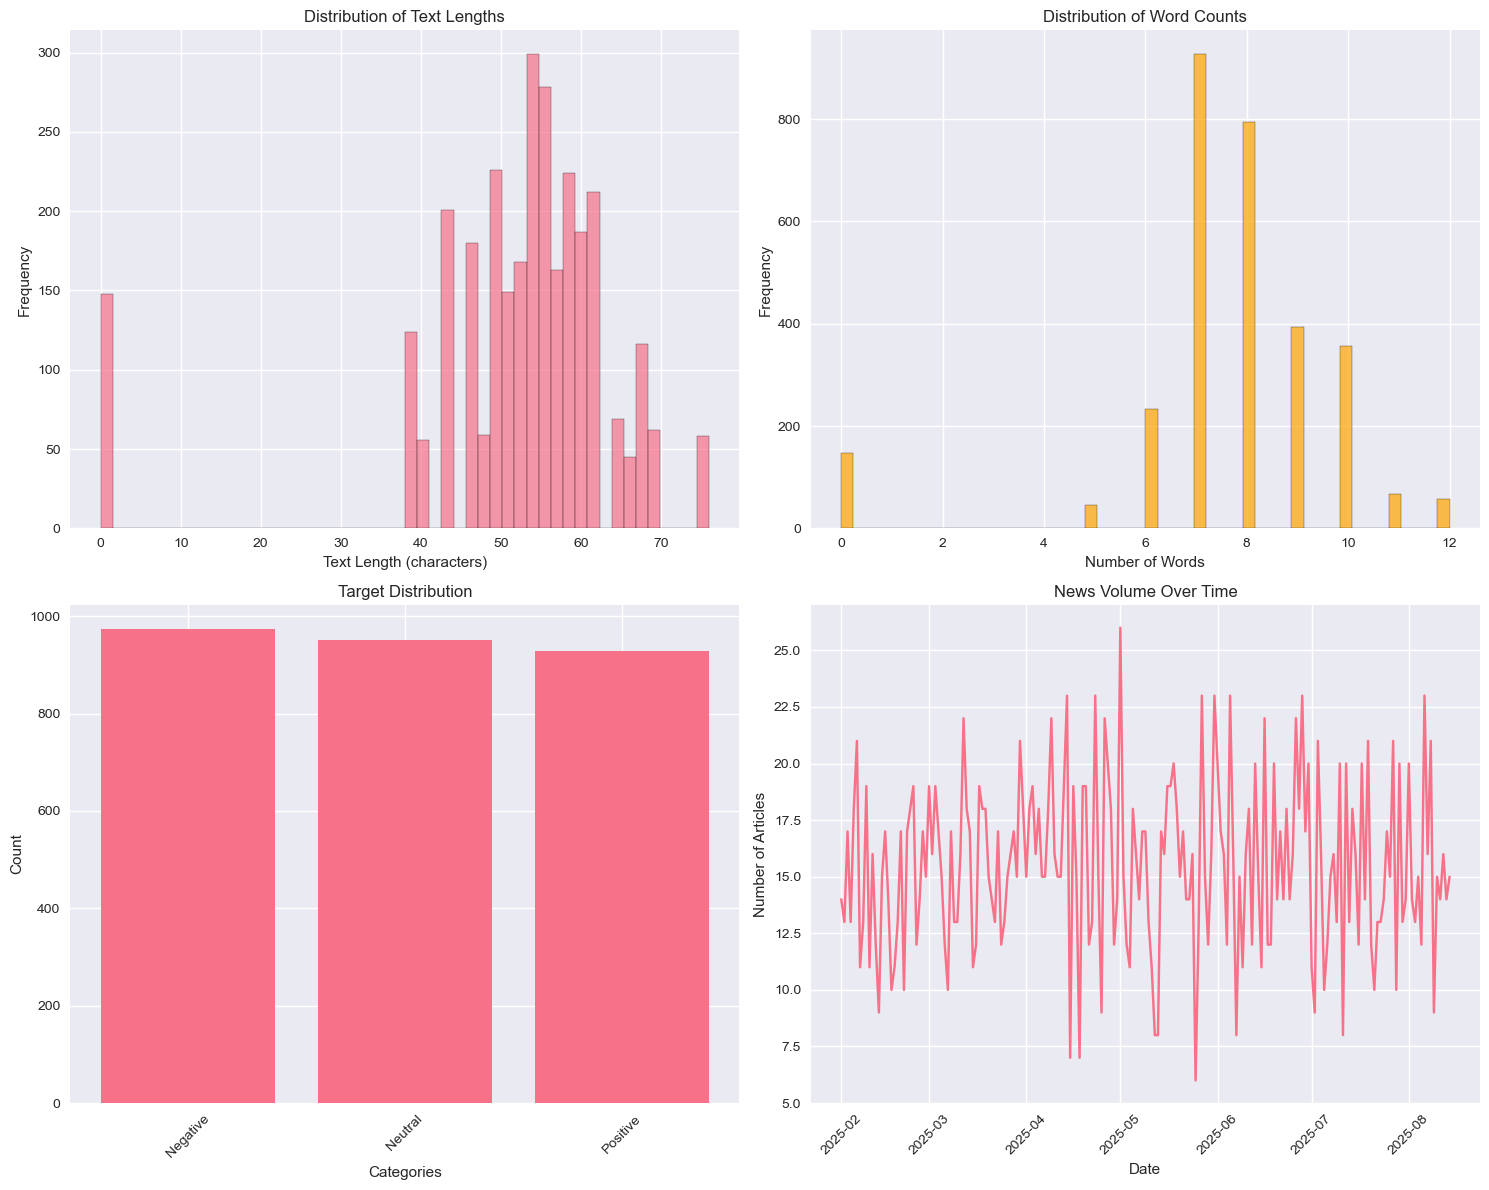


💭 STEP 3: Sentiment Analysis

🔤 STEP 4: NLP Feature Extraction

📈 STEP 5: Text Visualizations

❌ ERROR: 
**********************************************************************
  Resource punkt_tab not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('punkt_tab')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load tokenizers/punkt_tab/english/

  Searched in:
    - '/Users/bewaa/nltk_data'
    - '/opt/anaconda3/nltk_data'
    - '/opt/anaconda3/share/nltk_data'
    - '/opt/anaconda3/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************

Please check your data files and dependencies

🎊 FINANCIAL NEWS NLP ANALYSIS TOOLKIT READY FOR KAGGLE! 🎊


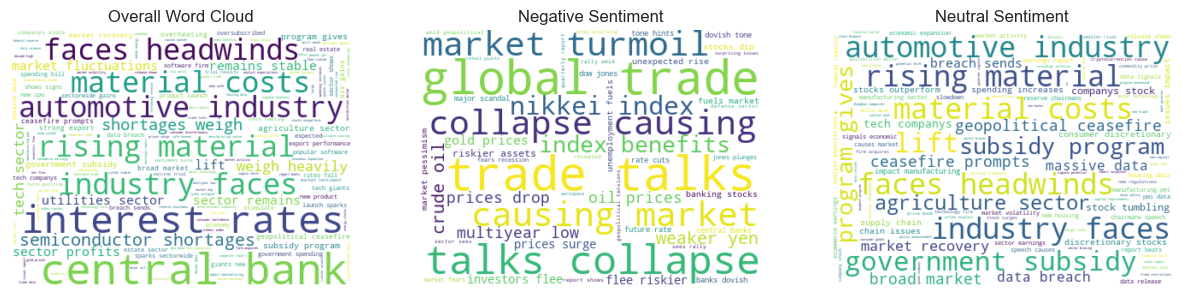

In [26]:
# =============================================================================
# RUN COMPREHENSIVE ANALYSIS
# =============================================================================

if __name__ == "__main__":
    # Run the comprehensive analysis
    try:
        final_df, executive_summary = comprehensive_analysis()
        
        if final_df is not None:
            print("\n✅ SUCCESS: Your financial news NLP analysis is complete!")
            print(f"📊 Analyzed {len(final_df):,} articles")
            print(f"🎯 Generated comprehensive insights and visualizations")
            print(f"💾 All results saved for Kaggle submission")
            
        else:
            print("\n❌ ANALYSIS FAILED: Please check your data files and try again")
            
    except Exception as e:
        print(f"\n❌ ERROR: {str(e)}")
        print("Please check your data files and dependencies")

print("\n" + "="*80)
print("🎊 FINANCIAL NEWS NLP ANALYSIS TOOLKIT READY FOR KAGGLE! 🎊")
print("="*80)